# Tutorial 04: Package Capabilities - A Use-Case Driven Guide

## Overview

This tutorial surveys the capabilities of `ssm-simulators` organized around the two core use-cases that `ssm-simulators` is build around.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# ssms imports
from ssms.config import model_config
from ssms.basic_simulators import Simulator
from ssms.dataset_generators.lan_mlp import DataGenerator
from ssms.config.generator_config.data_generator_config import get_default_generator_config

## Section 1: What Can ssm-simulators Do?

The `ssm-simulators` package provides two main capabilities:

<div style="max-width: 800px; margin: 30px auto;">
  <table style="width: 100%; border-collapse: separate; border-spacing: 0; margin-bottom: 30px;">
    <tr>
      <td style="padding: 25px; background-color: #e3f2fd; border: 3px solid #1976d2; border-radius: 8px; text-align: center;">
        <div style="font-size: 28px; margin-bottom: 15px;">🎲</div>
        <div style="font-weight: 700; font-size: 18px; margin-bottom: 15px; color: #0d47a1;">1. SIMULATE FROM MODELS</div>
        <div style="font-size: 14px; color: #555; line-height: 1.8;">
          <strong>100+ pre-built models</strong><br/>
          Fast C/Cython implementations<br/>
          Flexible parameterization
        </div>
      </td>
    </tr>
  </table>
  
  <div style="text-align: center; font-size: 24px; color: #666; margin: 20px 0;">↓</div>
  
  <table style="width: 100%; border-collapse: separate; border-spacing: 0;">
    <tr>
      <td style="padding: 25px; background-color: #f3e5f5; border: 3px solid #7b1fa2; border-radius: 8px; text-align: center;">
        <div style="font-size: 28px; margin-bottom: 15px;">🧠</div>
        <div style="font-weight: 700; font-size: 18px; margin-bottom: 15px; color: #4a148c;">2. GENERATE TRAINING DATA</div>
        <div style="font-size: 14px; color: #555; line-height: 1.8;">
          For neural inference (LAN)<br/>
          Auxiliary Labels for other networks<br/>
          Generation supports parallelism
        </div>
      </td>
    </tr>
  </table>
</div>

The tutorial below covers both aspects in some detail, however please be invited to check out
our dedicated turials for more information and examples.

### Use Case Navigation

Choose your goal:
- **Want to simulate?** → Section 2
- **Want to train neural networks?** → Section 3

---
## Use Case 1 - "I want to simulate data from a model"

### Available Models

The package includes 100+ pre-built sequential sampling models across several categories:

In [2]:
# Show the first 20 model names
all_models = list(model_config.keys())
print(f"Total available models: {len(all_models)}\n")
print("First 20 models:")
for i, model in enumerate(all_models[:20], 1):
    print(f"{i:2}. {model}")
print("...")

Total available models: 106

First 20 models:
 1. ddm
 2. ddm_st
 3. ddm_truncnormt
 4. ddm_rayleight
 5. ddm_sdv
 6. ddm_par2
 7. ddm_par2_no_bias
 8. ddm_par2_conflict_gamma_no_bias
 9. ddm_par2_angle_no_bias
10. ddm_par2_weibull_no_bias
11. ddm_seq2
12. ddm_seq2_no_bias
13. ddm_seq2_conflict_gamma_no_bias
14. ddm_seq2_angle_no_bias
15. ddm_seq2_weibull_no_bias
16. ddm_mic2_adj
17. ddm_mic2_adj_no_bias
18. ddm_mic2_adj_conflict_gamma_no_bias
19. ddm_mic2_adj_angle_no_bias
20. ddm_mic2_adj_weibull_no_bias
...


### Model Categories

Below we list some of the available model categories that can be accessed through `ssm-simulators`.
This list is evolving and in general, we advise the use to check available models by running the package
in the latest version.

However as an orientation and initial overview please see the table below:

| Category | Examples | Description |
|----------|----------|-------------|
| **Basic DDM** | ddm, angle, weibull, ornstein | Standard drift-diffusion variants |
| **Race Models** | lba_2, lba_3, race_* | Linear ballistic accumulator and race models |
| **LCA Models** | lca_3, lca_4, lca_no_bias_* | Leaky competing accumulator |
| **Collapsing Bounds** | angle, weibull_cdf, generalized_logistic | Time-varying decision boundaries |
| **Leaky Integration** | ornstein, ornstein_angle | Leaky/unstable accumulators |
| **Dynamic Drift** | gamma_drift, conflict_*, attend_* | Time-dependent evidence accumulation |
| **Full DDM** | full_ddm, ddm_sdv, ddm_st | Inter-trial variability |
| **Non-Gaussian** | levy, levy_angle | Alpha-stable noise processes |

### Quick Simulation

Let's simulate from a few different models:

In [3]:
# Example 1: Basic DDM
sim_ddm = Simulator(model="ddm")
data_ddm = sim_ddm.simulate(
    theta={"v": 1.0, "a": 1.5, "z": 0.5, "t": 0.3},
    n_samples=1000
)

print(f"Simulated {len(data_ddm['rts'])} trials")
print(f"Choice distribution: {np.unique(data_ddm['choices'], return_counts=True)}")
print(f"Mean RT: {np.mean(np.abs(data_ddm['rts'])):.3f}s")

Simulated 1000 trials
Choice distribution: (array([-1,  1], dtype=int32), array([ 45, 955]))
Mean RT: 1.683s


In [4]:
# Example 2: DDM with collapsing bounds (angle)
sim_angle = Simulator(model="angle")
data_angle = sim_angle.simulate(
    theta={"v": 1.0, "a": 1.5, "z": 0.5, "t": 0.3, "theta": 0.8},
    n_samples=1000
)

print(f"Simulated {len(data_angle['rts'])} trials")
print(f"Choice distribution: {np.unique(data_angle['choices'], return_counts=True)}")
print(f"Mean RT: {np.mean(np.abs(data_angle['rts'])):.3f}s")

Simulated 1000 trials
Choice distribution: (array([-1,  1], dtype=int32), array([161, 839]))
Mean RT: 0.927s


In [5]:
# Example 3: 3-choice LBA (race model)
sim_lba = Simulator(model="lba3")
data_lba = sim_lba.simulate(
    theta={"v0": 1.5, "v1": 1.0, "v2": 0.8, "A": 0.5, "b": 1.5, "t": 0.3},
    n_samples=1000
)

print(f"Simulated {len(data_lba['rts'])} trials")
print(f"Choice distribution:")
choices, counts = np.unique(data_lba['choices'], return_counts=True)
for choice, count in zip(choices, counts):
    print(f"  Choice {int(choice)}: {count} ({count/len(data_lba['rts'])*100:.1f}%)")
print(f"Mean RT: {np.mean(data_lba['rts']):.3f}s")

Simulated 1000 trials
Choice distribution:
  Choice 0: 978 (97.8%)
  Choice 1: 21 (2.1%)
  Choice 2: 1 (0.1%)
Mean RT: 0.837s


### Understanding Simulation Output

The simulation output is a dictionary with the following structure:

In [6]:
# Examine the structure of simulation output
for key, value in data_ddm.items():
    print(f"{key}:")
    if isinstance(value, np.ndarray):
        print(f"  Type: numpy array")
        print(f"  Shape: {value.shape}")
        print(f"  Sample values: {value[:5]}")
    else:
        print(f"  Type: {type(value)}")
        print(f"  Value: {value}")
    print()

rts:
  Type: numpy array
  Shape: (1000, 1)
  Sample values: [[1.8085301]
 [4.4508   ]
 [0.9011868]
 [1.9454144]
 [1.8400803]]

choices:
  Type: numpy array
  Shape: (1000, 1)
  Sample values: [[1]
 [1]
 [1]
 [1]
 [1]]

metadata:
  Type: <class 'dict'>
  Value: {'simulator': 'ddm_flexbound', 'possible_choices': [-1, 1], 'n_samples': 1000, 'n_trials': 1, 'boundary_fun_type': 'constant', 'v': array([1.], dtype=float32), 'a': array([1.5], dtype=float32), 'z': array([0.5], dtype=float32), 't': array([0.3], dtype=float32), 's': array([1.], dtype=float32), 'deadline': array([999.], dtype=float32), 'delta_t': 0.0010000000474974513, 'max_t': 20.0, 'boundary': array([1.5, 1.5, 1.5, ..., 1.5, 1.5, 1.5], shape=(20001,), dtype=float32), 'trajectory': array([[ 0.0000000e+00],
       [-6.1545940e-04],
       [ 1.4461258e-02],
       ...,
       [-9.9900000e+02],
       [-9.9900000e+02],
       [-9.9900000e+02]], shape=(20001, 1), dtype=float32), 'model': 'ddm'}



**Key fields:**

- **`rts`**: Reaction times (signed for 2-choice models: negative = lower boundary, positive = upper boundary)
- **`choices`**: Choice outcomes (e.g., -1, 1 for 2-choice; 0, 1, 2 for 3-choice)
- **`metadata`**: Additional simulation information (if any)

**Important notes:**
- For 2-choice models: RT sign encodes which boundary was crossed
- For multi-choice models: RT is unsigned, choice indicates which accumulator won
- RTs include non-decision time (`t` parameter)

### Visualizing Simulations

Let's create visualizations to understand the simulation results:

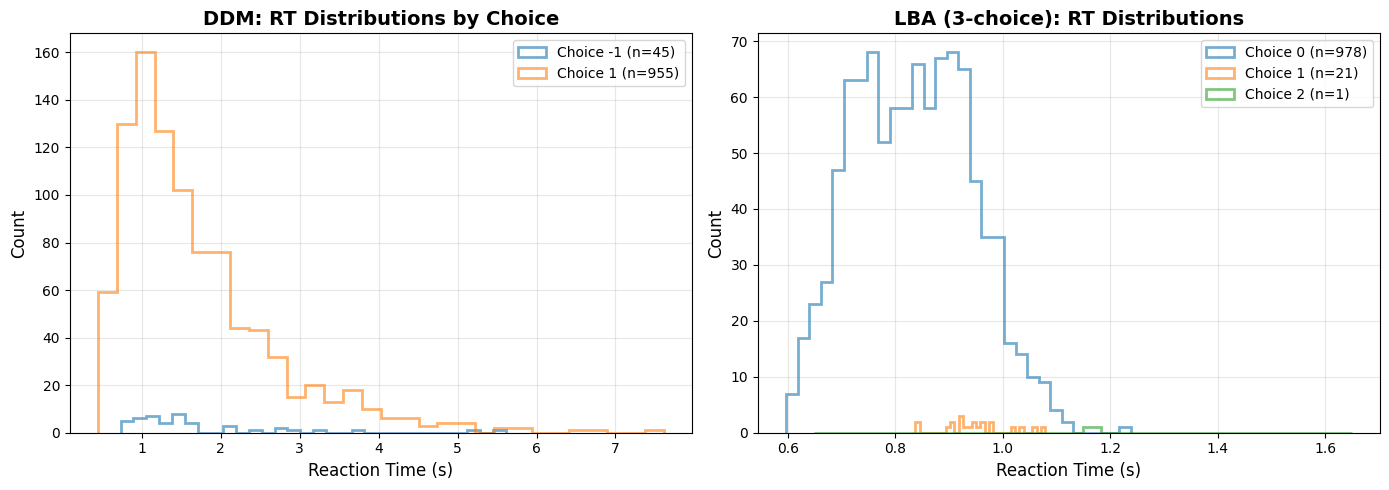

In [7]:
# Visualization 1: RT Histograms by choice
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DDM (2 choices)
for choice_val in [-1, 1]:
    mask = data_ddm['choices'] == choice_val
    rts = np.abs(data_ddm['rts'][mask])
    label = f"Choice {choice_val} (n={mask.sum()})"
    axes[0].hist(rts, bins=30, alpha=0.6, label=label, histtype='step', linewidth=2)

axes[0].set_xlabel('Reaction Time (s)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('DDM: RT Distributions by Choice', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# LBA (3 choices)
for choice_val in [0, 1, 2]:
    mask = data_lba['choices'] == choice_val
    rts = data_lba['rts'][mask]
    label = f"Choice {choice_val} (n={mask.sum()})"
    axes[1].hist(rts, bins=30, alpha=0.6, label=label, histtype='step', linewidth=2)

axes[1].set_xlabel('Reaction Time (s)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('LBA (3-choice): RT Distributions', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

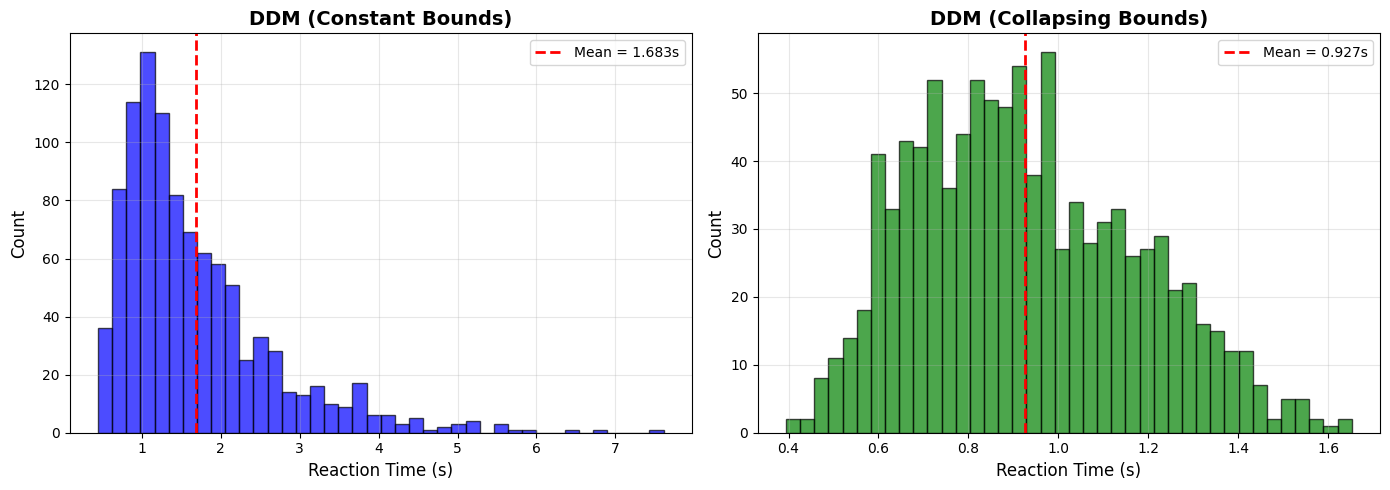


Constant bounds mean RT: 1.683s
Collapsing bounds mean RT: 0.927s
Difference: 0.756s (44.9% faster)


In [8]:
# Visualization 2: Compare constant vs collapsing bounds
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DDM with constant bounds
rts_ddm = np.abs(data_ddm['rts'])
axes[0].hist(rts_ddm, bins=40, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(np.mean(rts_ddm), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(rts_ddm):.3f}s')
axes[0].set_xlabel('Reaction Time (s)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('DDM (Constant Bounds)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# DDM with collapsing (angle) bounds
rts_angle = np.abs(data_angle['rts'])
axes[1].hist(rts_angle, bins=40, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(np.mean(rts_angle), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(rts_angle):.3f}s')
axes[1].set_xlabel('Reaction Time (s)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('DDM (Collapsing Bounds)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConstant bounds mean RT: {np.mean(rts_ddm):.3f}s")
print(f"Collapsing bounds mean RT: {np.mean(rts_angle):.3f}s")
print(f"Difference: {np.mean(rts_ddm) - np.mean(rts_angle):.3f}s ({(np.mean(rts_ddm) - np.mean(rts_angle))/np.mean(rts_ddm)*100:.1f}% faster)")

### 3.1 What is LAN?

**Likelihood Approximation Networks (LAN)** are neural networks trained to approximate the likelihood function of a model. This enables:

- **Amortized inference**: Train once, infer many times
- **Fast posterior estimation**: No MCMC required
- **Scalability**: Can handle complex hierarchical models

**The training data generation process:**

<div style="max-width: 700px; margin: 30px auto;">
  <table style="width: 100%; border-collapse: separate; border-spacing: 0;">
    <tr>
      <td style="padding: 20px; background-color: #fff3e0; border: 3px solid #ff6f00; border-radius: 8px; text-align: center;">
        <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #e65100;">📊 Parameter Space Sampling</div>
        <div style="font-size: 13px; color: #555;">Sample parameter combinations from bounds</div>
      </td>
    </tr>
  </table>
  
  <div style="text-align: center; font-size: 24px; color: #666; margin: 15px 0;">↓</div>
  
  <table style="width: 100%; border-collapse: separate; border-spacing: 0;">
    <tr>
      <td style="padding: 20px; background-color: #e8f5e9; border: 3px solid #2e7d32; border-radius: 8px;">
        <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #1b5e20; text-align: center;">🔄 For each parameter set:</div>
        <div style="font-size: 13px; color: #555; line-height: 1.8; margin-left: 20px;">
          1. Simulate trials<br/>
          2. Compute likelihoods (KDE or analytical)<br/>
          3. Generate auxiliary labels
        </div>
      </td>
    </tr>
  </table>
  
  <div style="text-align: center; font-size: 24px; color: #666; margin: 15px 0;">↓</div>
  
  <table style="width: 100%; border-collapse: separate; border-spacing: 0;">
    <tr>
      <td style="padding: 20px; background-color: #f3e5f5; border: 3px solid #7b1fa2; border-radius: 8px;">
        <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #4a148c; text-align: center;">📦 Training Dataset</div>
        <div style="font-size: 13px; color: #555; line-height: 1.8; margin-left: 20px;">
          <strong>• theta:</strong> Parameters<br/>
          <strong>• lan_features:</strong> Features (theta, RTs, choices)<br/>
          <strong>• lan_labels:</strong> Log-likelihoods<br/>
          <strong>• auxiliary labels:</strong> choice_p, omission_p, etc.
        </div>
      </td>
    </tr>
  </table>
</div>

### Basic Training Data Generation

Let's generate a small training dataset for a DDM:

In [9]:
# Get default LAN config and customize for quick demo
config = get_default_generator_config("lan")

# Make it small for demonstration
config["pipeline"]["n_parameter_sets"] = 20  # Just 5 parameter sets
config["training"]["n_samples_per_param"] = 50  # 50 training samples each
config["simulator"]["n_samples"] = 1000  # 1000 simulation trials per parameter set
config["simulator"]["delta_t"] = 0.01  # Coarser time resolution for speed

print("Generator config (demonstration settings):")
print("=" * 60)
print(f"Parameter sets to sample: {config['pipeline']['n_parameter_sets']}")
print(f"Training samples per param: {config['training']['n_samples_per_param']}")
print(f"Simulation trials per param: {config['simulator']['n_samples']}")
print(f"Time resolution (delta_t): {config['simulator']['delta_t']}")

Generator config (demonstration settings):
Parameter sets to sample: 20
Training samples per param: 50
Simulation trials per param: 1000
Time resolution (delta_t): 0.01


In [10]:
# Generate training data
gen = DataGenerator(config, model_config["ddm"])
training_data = gen.generate_data_training(save=False)

print("\n✓ Training data generated!")
print(f"\nDataset structure:")
for key, value in training_data.items():
    if isinstance(value, np.ndarray):
        print(f"  {key}: shape {value.shape}, dtype {value.dtype}")
    else:
        print(f"  {key}: {type(value)}")


✓ Training data generated!

Dataset structure:
  cpn_no_omission_labels: shape (20,), dtype float32
  opn_labels: shape (20, 1), dtype float32
  cpn_labels: shape (20,), dtype float32
  cpn_no_omission_data: shape (20, 4), dtype float32
  binned_256: shape (20, 256, 2), dtype float32
  lan_data: shape (1000, 6), dtype float32
  opn_data: shape (20, 4), dtype float32
  theta: shape (20, 4), dtype float32
  binned_128: shape (20, 128, 2), dtype float32
  gonogo_labels: shape (20, 1), dtype float32
  gonogo_data: shape (20, 4), dtype float32
  lan_labels: shape (1000,), dtype float32
  cpn_data: shape (20, 4), dtype float32
  generator_config: <class 'dict'>
  model_config: <class 'dict'>


### Training Data Structure

The training dataset contains several components:

In [11]:
# Examine the training data in detail

# theta - parameter samples
print("\n1. theta (parameter samples):")
print(f"   Shape: {training_data['theta'].shape}")
print(f"   Interpretation: {training_data['theta'].shape[0]} parameter sets")
print(f"   Parameters: v, a, z, t")
print(f"   First 3 sets:")
for i in range(min(3, len(training_data['theta']))):
    print(f"     Set {i}: {training_data['theta'][i]}")

# lan_data - features (RTs and choices)
print("\n2. lan data (features - RTs and choices):")
print(f"   Shape: {training_data['lan_data'].shape}")
print(f"   Interpretation: {training_data['lan_data'].shape[0]} training samples,")
print(f"                   each with {training_data['lan_data'].shape[1]} trials")
print(f"   Format: [RT, choice] pairs")
print(f"   First sample (2 trials shown):")
for i in range(min(5, training_data['lan_data'].shape[1])):
    print(f"     Trial {i}: RT={training_data['lan_data'][i,-2]:.3f}, choice={training_data['lan_data'][i,-1]:.0f}")

# lan_labels - log-likelihoods
print("\n3. lan labels (log-likelihoods):")
print(f"   Shape: {training_data['lan_labels'].shape}")
print(f"   Interpretation: Log-likelihood for each trial in each sample")
print(f"   First sample (3 trials shown):")
print(f"     {training_data['lan_labels'][:3]}")


1. theta (parameter samples):
   Shape: (20, 4)
   Interpretation: 20 parameter sets
   Parameters: v, a, z, t
   First 3 sets:
     Set 0: [-2.754159    0.8935308   0.6095694   0.03305527]
     Set 1: [-2.1350424  2.39102    0.5094573  1.8972989]
     Set 2: [1.8853544  0.95668054 0.3092897  0.18383189]

2. lan data (features - RTs and choices):
   Shape: (1000, 6)
   Interpretation: 1000 training samples,
                   each with 6 trials
   Format: [RT, choice] pairs
   First sample (2 trials shown):
     Trial 0: RT=0.324, choice=-1
     Trial 1: RT=0.616, choice=-1
     Trial 2: RT=0.339, choice=-1
     Trial 3: RT=0.218, choice=-1
     Trial 4: RT=1.082, choice=-1

3. lan labels (log-likelihoods):
   Shape: (1000,)
   Interpretation: Log-likelihood for each trial in each sample
   First sample (3 trials shown):
     [ 0.86681426 -0.20462832  0.83278775]


**Key Components Explained:**

1. **`theta`**: Sampled parameter values
   - Shape: `(n_parameter_sets, n_params)`
   - Each row is a parameter combination sampled from the parameter space

2. **`lan_data`**: Feature matrix (inputs to the neural network)
   - Shape: `(n_training_samples * n_trials, model_params + 2)`
   - Last dimension: `[RT, choice]`
   - Training samples are drawn from simulations for each parameter set

3. **`labels`**: Log-likelihood for each trial
   - Shape: `(n_training_samples * n_trials)`
   - Target outputs for the neural network
   - Computed using KDE or analytical PDFs

4. **Auxiliary labels**: Additional target outputs (see next section)

### Understanding Auxiliary Labels

Auxiliary labels provide additional training targets for specialized neural networks:

In [12]:
# Examine auxiliary labels
auxiliary_keys = ['choice_p', 'omission_p', 'choice_p_no_omission', 'nogo_p']
for key in auxiliary_keys:
    if key in training_data:
        print(f"\n{key}:")
        print(f"  Shape: {training_data[key].shape}")
        print(f"  Description: ", end="")
        if key == 'choice_p':
            print("Probability of each choice")
        elif key == 'omission_p':
            print("Probability of no response (omission)")
        elif key == 'choice_p_no_omission':
            print("Choice probabilities conditional on responding")
        elif key == 'nogo_p':
            print("No-go probability")
        
        # Show a sample
        print(f"  Sample values (first 2 parameter sets):")
        for i in range(min(2, len(training_data[key]))):
            print(f"    Set {i}: {training_data[key][i]}")

**Auxiliary Label Applications:**

1. **`choice_p`**: Train choice probability networks
   - Useful for fitting data with only choice information (no RTs)
   - Can be used for model comparison

2. **`omission_p`**: Model response omissions
   - Important for experiments with deadlines or time pressure
   - Captures fast guesses vs timed-out trials

3. **`choice_p_no_omission`**: Choice probabilities given a response occurred
   - Useful when omissions are treated separately
   - Conditional probability: P(choice | response made)

4. **`nogo_p`**: No-go trial probabilities
   - Relevant for go/no-go tasks
   - Models inhibition failures


The auxiliary labels enable training specialized networks for different inference tasks.